In [26]:
import pandas as pd
from pathlib import Path
import polars as pl

data_root = Path("../kkdata3/")
train_source = pd.read_parquet(data_root / "label_train_source.parquet")
train_target = pd.read_parquet(data_root / "label_train_target.parquet")
test_source = pd.read_parquet(data_root / "label_test_source.parquet")
meta_song = pd.read_parquet(data_root / "meta_song.parquet")
meta_song_composer = pd.read_parquet(data_root / "meta_song_composer.parquet")
meta_song_genre = pd.read_parquet(data_root / "meta_song_genre.parquet")
meta_song_lyricist = pd.read_parquet(data_root / "meta_song_lyricist.parquet")
meta_song_producer = pd.read_parquet(data_root / "meta_song_producer.parquet")
meta_song_titletext = pd.read_parquet(data_root / "meta_song_titletext.parquet")


train_source.dtypes

session_id          int64
song_id            object
unix_played_at      int64
play_status         int64
login_type          int64
listening_order     int64
dtype: object

In [27]:
train_source.sort_values(["session_id", "listening_order"], inplace=True)
train_target.sort_values(["session_id", "listening_order"], inplace=True)
# test_source.sort_values(["session_id", "listening_order"], inplace=True)

In [28]:
# map song_id to song_index to save memory and speed up
meta_song["song_index"] = meta_song.index
train_source = train_source.merge(
    meta_song[["song_id", "song_index"]], on="song_id", how="left"
)
train_target = train_target.merge(
    meta_song[["song_id", "song_index"]], on="song_id", how="left"
)
test_source = test_source.merge(
    meta_song[["song_id", "song_index"]], on="song_id", how="left"
)

unix to datatime

In [29]:
from datetime import datetime

train_source["unix_played_at"] = pd.to_datetime(
    train_source["unix_played_at"], unit="s"
)
train_target["unix_played_at"] = pd.to_datetime(
    train_target["unix_played_at"], unit="s"
)
test_source["unix_played_at"] = pd.to_datetime(test_source["unix_played_at"], unit="s")

merge languange

In [30]:
# train_source = train_source.merge(
#     meta_song[["song_index", "language_id"]], on="song_index", how="left"
# )

## play_status: online-downloaded > online-streaming > offline-downloaded


Train_source status rate == Train_target status rate 

play_status
 0    4560772
 1    3411409
 2    3280395
 4     181491
 3       8496
 8       1685
-1        926
 7          6
Name: count, dtype: int64

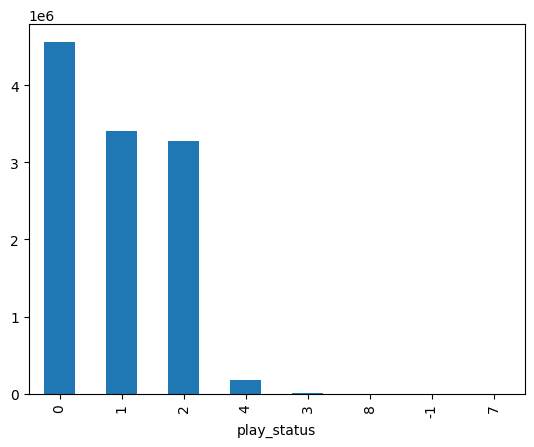

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

play_status_cnt = train_source.play_status.value_counts()
play_status_cnt.plot(kind="bar")
play_status_cnt

<Axes: ylabel='count'>

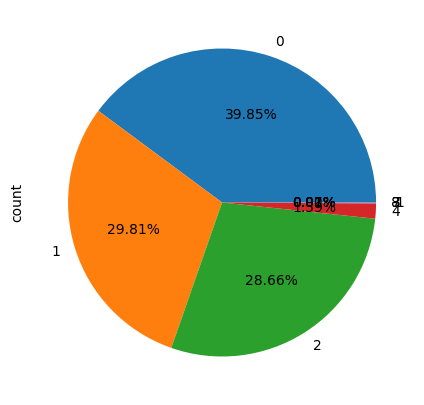

In [32]:
plt.figure(figsize=(5, 5))
play_status_cnt.plot.pie(autopct="%.2f%%", shadow=False)

play_status
 0    1120293
 1     862669
 2     829440
 4      46159
 3       2204
 8        309
-1        221
Name: count, dtype: int64

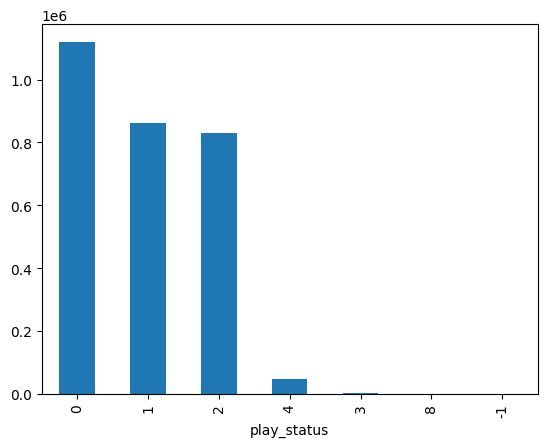

In [33]:
play_status_cnt_tgt = train_target.play_status.value_counts()

play_status_cnt_tgt.plot(kind="bar")
play_status_cnt_tgt

## Language: Mandarin>English=Japanese>Korean>Cantonese>>Hokkien

In [34]:
train_source = train_source.merge(
    meta_song[["song_index", "language_id"]], on="song_index", how="left"
)

<Axes: ylabel='count'>

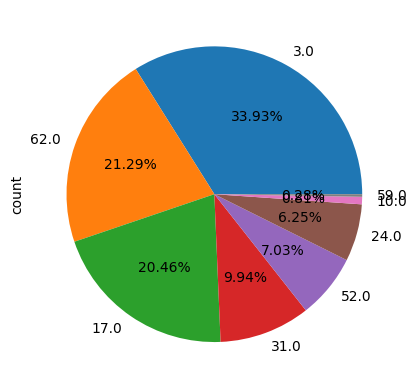

In [35]:
train_source["language_id"].value_counts().head(8).plot.pie(autopct="%.2f%%")

<Axes: xlabel='language_id'>

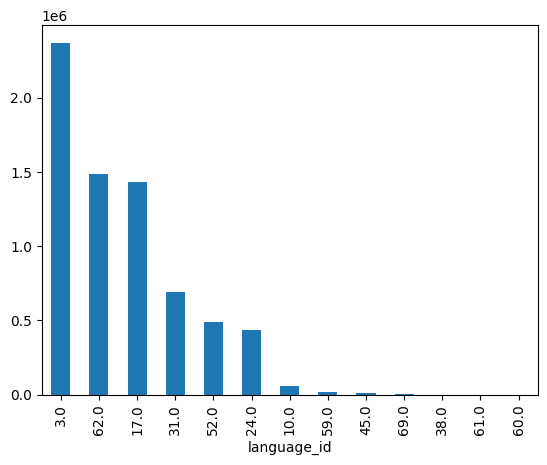

In [36]:
# merge language
train_source["language_id"].value_counts().plot(kind="bar")

## Login Type : 7 >> 8 > 49=47

<Axes: ylabel='count'>

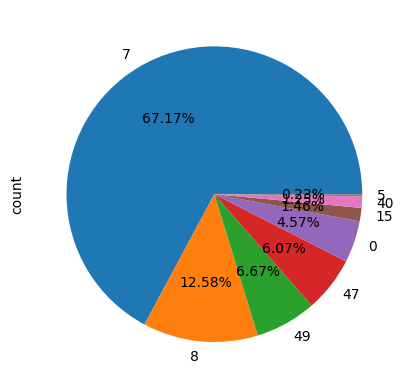

In [37]:
# merge language
train_source["login_type"].value_counts().head(8).plot.pie(autopct="%.2f%%")

### Language miss rate : 38.83

In [38]:
train_source["language_id"].isna().sum() / len(train_source) * 10000 // 1 / 100

38.83

## song_id simple explore

### Song_id miss rate: 0

In [39]:
train_source["song_index"].isna().sum() / len(train_source) * 10000 // 1 / 100

0.0


### If every session has 20 songs :  True

In [40]:
(train_source["listening_order"] == 20).sum() == len(train_source) // 20

True

### train_source's song_index unique rate : 5.68

In [41]:
train_source["song_index"].nunique() / len(train_source) * 10000 // 1 / 100

5.68

## Genre =>Pop> Japanese > Western > Mandarin > Rock/Alternative > Electronic/Dance > Hip-Hop/Rap

### Genre miss rate = 0

In [42]:
meta_song_genre.genre_id.isna().sum() / len(meta_song_genre) * 10000 // 1 / 100

0.0

### Multi Genre rate :1.64

In [43]:
len(meta_song_genre) / meta_song_genre["song_id"].nunique() * 100 // 1 / 100

1.64

In [44]:
meta_song_genre

,song_id,genre_id
0,7366ba2acd92eb262191bdaedf249462,b856b6781d370a3645c6dde0c20b3597
1,0b016dad8634acec9d9156d75c3ca568,2eabe9f164346c7b3ff1bd23078f483e
2,0145eadf202d4c7305aec592f7b9a50b,bb3d7b04b67d5aeb5ab145bdd70750da
3,7380f3306b88887be62fabdfc18925c9,b856b6781d370a3645c6dde0c20b3597
4,0006518b7b5daceacc4acf0c3f2843b8,2eabe9f164346c7b3ff1bd23078f483e
...,...,...
1161950,fae89ce7d4c4afe996b82ba0f14cd024,65aeeca3341ca1c6a2ed774aa4e22add
1161951,6ae20625078e15fdbe516c6f03fb7521,1d7c8bb87dcc1457ed90240c06f9ebdf
1161952,16ce1c2ec0f86418f9b37a45d7a7f1d0,b856b6781d370a3645c6dde0c20b3597
1161953,82c57ad358fa3bbf71080b53588dc6cb,6ea61b86b8fff0e3a05bc73ea4eaf21f


<Axes: ylabel='count'>

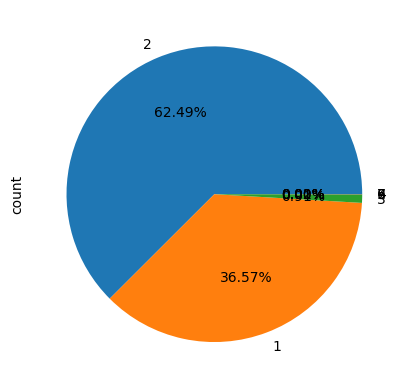

In [45]:
mr_genre = meta_song_genre.groupby("song_id").agg({"genre_id": "count"}).reset_index()
mr_genre.sort_values("genre_id", ascending=False).value_counts("genre_id").plot.pie(
    autopct="%.2f%%"
)

### Genre :  Pop> Japanese > Western > Mandarin > Rock/Alternative > Electronic/Dance > Hip-Hop/Rap


<Axes: ylabel='count'>

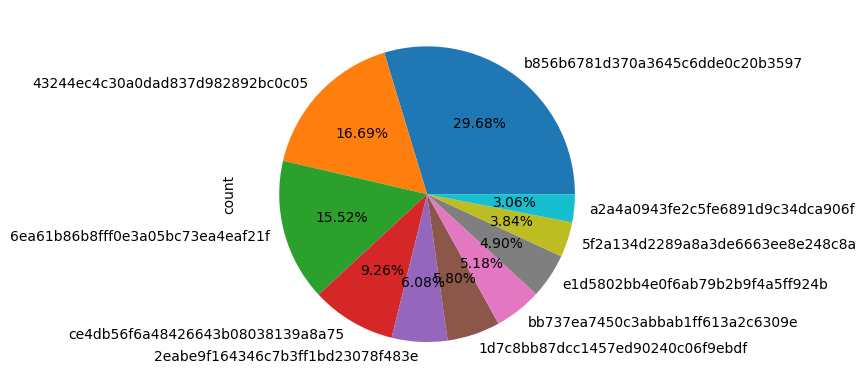

In [46]:
meta_song_genre.genre_id.value_counts().head(10).plot.pie(autopct="%.2f%%")

In [47]:
meta_song_genre.genre_id.value_counts().head(10)

genre_id
b856b6781d370a3645c6dde0c20b3597    299342
43244ec4c30a0dad837d982892bc0c05    168341
6ea61b86b8fff0e3a05bc73ea4eaf21f    156540
ce4db56f6a48426643b08038139a8a75     93373
2eabe9f164346c7b3ff1bd23078f483e     61287
1d7c8bb87dcc1457ed90240c06f9ebdf     58462
bb737ea7450c3abbab1ff613a2c6309e     52278
e1d5802bb4e0f6ab79b2b9f4a5ff924b     49370
5f2a134d2289a8a3de6663ee8e248c8a     38733
a2a4a0943fe2c5fe6891d9c34dca906f     30840
Name: count, dtype: int64

In [53]:
# Assuming meta_song_genre is your DataFrame
hash_ids = meta_song_genre["genre_id"].unique()

# Create a dictionary to store the mapping of hash IDs to numbers
hash_id_to_number = {hash_id: number for number, hash_id in enumerate(hash_ids)}

# Add a new column with the transformed numbers to the DataFrame
meta_song_genre["genre_number"] = meta_song_genre["genre_id"].map(hash_id_to_number)

# Print the corresponding dictionary
meta_song_genre

,song_id,genre_id,genre_number
0,7366ba2acd92eb262191bdaedf249462,b856b6781d370a3645c6dde0c20b3597,0
1,0b016dad8634acec9d9156d75c3ca568,2eabe9f164346c7b3ff1bd23078f483e,1
2,0145eadf202d4c7305aec592f7b9a50b,bb3d7b04b67d5aeb5ab145bdd70750da,2
3,7380f3306b88887be62fabdfc18925c9,b856b6781d370a3645c6dde0c20b3597,0
4,0006518b7b5daceacc4acf0c3f2843b8,2eabe9f164346c7b3ff1bd23078f483e,1
...,...,...,...
1161950,fae89ce7d4c4afe996b82ba0f14cd024,65aeeca3341ca1c6a2ed774aa4e22add,16
1161951,6ae20625078e15fdbe516c6f03fb7521,1d7c8bb87dcc1457ed90240c06f9ebdf,8
1161952,16ce1c2ec0f86418f9b37a45d7a7f1d0,b856b6781d370a3645c6dde0c20b3597,0
1161953,82c57ad358fa3bbf71080b53588dc6cb,6ea61b86b8fff0e3a05bc73ea4eaf21f,7


## Merge trainsrc with more info. composer_index, artist_id, genre_number

In [54]:
# Assuming meta_song_genre is your DataFrame
hash_ids = meta_song_composer["composer_id"].unique()

# Create a dictionary to store the mapping of hash IDs to numbers
hash_id_to_number = {hash_id: number for number, hash_id in enumerate(hash_ids)}

# Add a new column with the transformed numbers to the DataFrame
meta_song_composer["composer_index"] = meta_song_composer["composer_id"].map(
    hash_id_to_number
)

# Print the corresponding dictionary
meta_song_composer

,song_id,composer_id,composer_index
0,cdffd7270c86854d70d9475a1b5fa29f,bb78a094b2c1c2bfcb599690d0a34a75,0
1,8c8b365835227f50dd5058d89e42c675,61cf7925bbd9df77c0ad82250f990f91,1
2,dd10802f9920946e100f7e7e2a344e77,5438736174e7e946b3c701c9df8f7109,2
3,c6d491d202c50888e958dc90355e6832,af107e6808d25452b5bfa4641ff0f164,3
4,fb156641a27a3e9789b3cc07cf472514,2a769e2f05eac558307531ee0cb29646,4
...,...,...,...
820802,ffdc12bf5754e919b3ae4b5a177a915f,0e3c355a44785361b8d9f85b2b3e7b82,22800
820803,a87fd964206d8c02093aa8c637dde12d,d1aca2d0ae3ca764f80589f814ceb388,4455
820804,d4508a660eb86b09382dcc5dcf8ac063,40d3606a427dad912abf29b58d67a212,147791
820805,0df3c085ef1f79fef212ff05f25ff8f2,852fff48a35f18979ea01459db395a0d,15383


In [55]:
train_source

,session_id,song_id,unix_played_at,play_status,login_type,listening_order,song_index,language_id
0,1,f6f06a71bb8bc38af6c0b7dae9cab00d,2022-08-09 02:35:05,0,7,1,354121,3.0
1,1,7b48a87effd31c9c07b68ed212062854,2022-08-09 02:38:50,0,7,2,1030664,NaN
2,1,61c46d6401aab1dde7c7de23dc55c037,2022-08-09 03:18:33,0,7,3,642780,3.0
3,1,7e54c9199aad70e35fe256d23701bad0,2022-08-09 03:21:29,0,7,4,280721,3.0
4,1,6178580fa01b62e9b52787902c0d8ae6,2022-08-09 03:30:41,0,7,5,90293,3.0
...,...,...,...,...,...,...,...,...
11445175,715323,65a4fa6c28e6c640c30bb9567ec07358,2022-10-02 10:28:10,0,7,16,587574,62.0
11445176,715323,4c8a29c6fb363a1531a944fb978c4a0b,2022-10-02 10:31:05,0,7,17,152114,52.0
11445177,715323,88c2975000726c4c9f21fba913dab088,2022-10-02 10:35:29,0,7,18,422873,62.0
11445178,715323,9c6ce0c23159646a6acf5dd8e9f39a19,2022-10-02 10:38:49,0,7,19,935208,NaN


In [56]:
# add genre column to source
train_source_genr = train_source.merge(
    meta_song_genre[["song_id", "genre_number"]], on="song_id", how="left"
)

# add artist column to source
train_source_genr_artist = train_source_genr.merge(
    meta_song[["song_id", "artist_id"]], on="song_id", how="left"
)

# add composer column to source
train_source_genr_artist_composer = train_source_genr_artist.merge(
    meta_song_composer[["song_id", "composer_index"]], on="song_id", how="left"
)

train_source_genr_artist_composer

,session_id,song_id,unix_played_at,play_status,login_type,listening_order,song_index,language_id,genre_number,artist_id,composer_index
0,1,f6f06a71bb8bc38af6c0b7dae9cab00d,2022-08-09 02:35:05,0,7,1,354121,3.0,0.0,2959458.0,11846.0
1,1,f6f06a71bb8bc38af6c0b7dae9cab00d,2022-08-09 02:35:05,0,7,1,354121,3.0,3.0,2959458.0,11846.0
2,1,7b48a87effd31c9c07b68ed212062854,2022-08-09 02:38:50,0,7,2,1030664,NaN,NaN,NaN,NaN
3,1,61c46d6401aab1dde7c7de23dc55c037,2022-08-09 03:18:33,0,7,3,642780,3.0,5.0,12719146.0,9945.0
4,1,61c46d6401aab1dde7c7de23dc55c037,2022-08-09 03:18:33,0,7,3,642780,3.0,5.0,12719146.0,6035.0
...,...,...,...,...,...,...,...,...,...,...,...
21030405,715323,88c2975000726c4c9f21fba913dab088,2022-10-02 10:35:29,0,7,18,422873,62.0,0.0,64006.0,21561.0
21030406,715323,88c2975000726c4c9f21fba913dab088,2022-10-02 10:35:29,0,7,18,422873,62.0,0.0,64006.0,4755.0
21030407,715323,88c2975000726c4c9f21fba913dab088,2022-10-02 10:35:29,0,7,18,422873,62.0,0.0,64006.0,13715.0
21030408,715323,9c6ce0c23159646a6acf5dd8e9f39a19,2022-10-02 10:38:49,0,7,19,935208,NaN,NaN,4261.0,1596.0


In [57]:
train_source_genr_artist_composer["genre_number"].isna().sum() / len(
    train_source_genr
) * 10000 // 1 / 100

29.51

### language simalar with genre_number, so we drop genre number colmunn. because it has more than 1 

In [58]:
train_target

,session_id,song_id,unix_played_at,play_status,login_type,listening_order,song_index
0,1,b186d853cb06ceba2bd56bcdc701b8aa,2022-08-09 03:42:11,0,7,21,624433
1,1,1071e128ee5f9e2a0f0be0aade025b39,2022-08-09 03:46:25,0,7,22,901147
2,1,0100af68f3477f6bf724664d0b303f29,2022-08-09 03:46:31,0,7,23,810092
3,1,22a696cede3609c20ba1bceb8de28032,2022-08-09 03:46:33,0,7,24,74420
4,1,d6476892c926c88c7f232fd800b75845,2022-08-09 03:48:22,0,7,25,250714
...,...,...,...,...,...,...,...
2861290,715323,d7031cd298948b2ca63565965eb77111,2022-10-02 10:39:45,0,7,21,355650
2861291,715323,4dc776fa7a8db1bbe647e580e69dca9d,2022-10-02 10:40:01,0,7,22,170449
2861292,715323,657cb54ed943148dc64f31b6de635591,2022-10-02 10:43:20,0,7,23,233843
2861293,715323,0a696d765856a7b48bae85715cca06b2,2022-10-02 10:44:09,0,7,24,931389


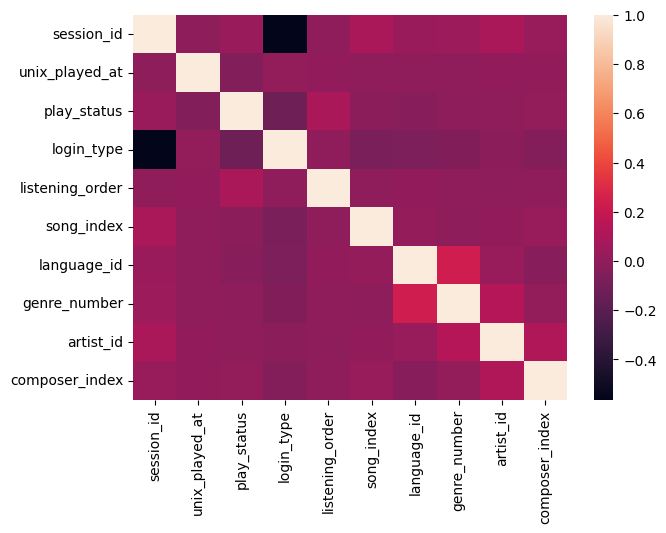

In [59]:
# heat map
train_source_genr_artist_composer.drop(columns=["song_id"], inplace=True)
plt.figure(figsize=[7, 5])
sns.heatmap(train_source_genr_artist_composer.corr())
plt.show()

## add artist & language , play_duration column


In [60]:
# prepare train data
# add artist & language column
_artist = train_source.merge(
    meta_song[["song_id", "artist_id"]], on="song_id", how="left"
)

df_train_x = _artist

# Calculate the play duration, set 20th song's play duration to NaN
df_train_x["play_duration"] = df_train_x.groupby("session_id")["unix_played_at"].diff()
df_train_x["play_duration"] = df_train_x["play_duration"].shift(-1)

# check each session has 20 songs
print(
    "check each session has 20 songs:",
    (df_train_x["listening_order"] == 20).sum() == len(df_train_x) // 20,
)
df_train_x = df_train_x.drop(columns=["song_id", "login_type", "unix_played_at"])

# handle nan
df_train_x["artist_id"].fillna(0, inplace=True)
df_train_x["language_id"].fillna(0, inplace=True)
df_train_x.head(25)

check each session has 20 songs: True


,session_id,play_status,listening_order,song_index,language_id,artist_id,play_duration
0,1,0,1,354121,3.0,2959458.0,0 days 00:03:45
1,1,0,2,1030664,0.0,0.0,0 days 00:39:43
2,1,0,3,642780,3.0,12719146.0,0 days 00:02:56
3,1,0,4,280721,3.0,40080.0,0 days 00:09:12
4,1,0,5,90293,3.0,55507.0,0 days 00:00:01
5,1,0,6,766515,0.0,13429875.0,0 days 00:00:04
6,1,0,7,769968,0.0,6651.0,0 days 00:00:00
7,1,0,8,1007853,0.0,23054840.0,0 days 00:00:02
8,1,0,9,249587,3.0,2424531.0,0 days 00:00:02
9,1,0,10,615299,3.0,15412497.0,0 days 00:00:02


In [61]:
# step1 - data cleaning
df_train_x["play_duration"] = df_train_x[
    "play_duration"
].dt.total_seconds()  # 將 play_duration 轉換為秒
df_train_x["play_duration"].fillna(0, inplace=True)

In [72]:
df_train_x.play_duration.describe()

count    1.144518e+07
mean     2.814950e+03
std      3.438241e+04
min      0.000000e+00
25%      3.000000e+00
50%      6.000000e+01
75%      2.230000e+02
max      7.800459e+06
Name: play_duration, dtype: float64

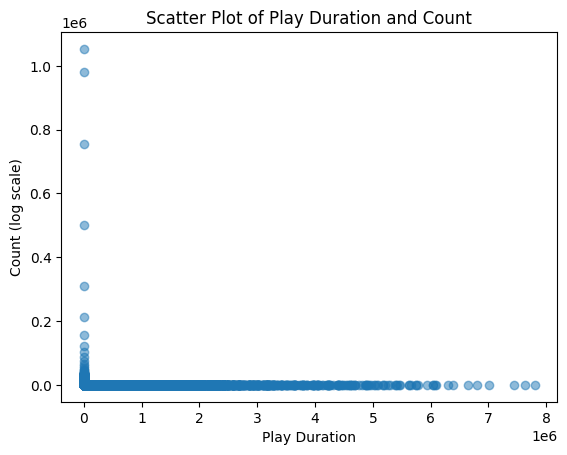

In [73]:
import matplotlib.pyplot as plt

play_duration_counts = df_train_x.play_duration.value_counts().sort_index()

# Plotting the scatter plot with a logarithmic y-axis
plt.scatter(play_duration_counts.index, play_duration_counts.values, alpha=0.5)
# plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility

# Adding labels and title
plt.xlabel("Play Duration")
plt.ylabel("Count (log scale)")
plt.title("Scatter Plot of Play Duration and Count")

# Display the plot
plt.show()